In [1]:
import numpy as np
import scipy
from scipy import integrate
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import time


In [2]:
def adjacency_matrix(N : int, spectral_radius : float = 0.9, density : float = 0.02):
    rng = np.random.default_rng(0) # Initialize the numpy random number generator
    current_time = time.time_ns()
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = rng.uniform(0, 1.0) if rng.uniform(0.0, 1.0) < density else 0.0
    elapsed_time = time.time_ns() - current_time 
    print("> First construction [time in s]: ", elapsed_time/1.e9)
    
    current_time = time.time_ns()
    current_spectral_radius = np.abs(np.linalg.eigvals(M)).max()
    elapsed_time = time.time_ns() - current_time 
    print("> Spectral radius computation [time in s]: ", elapsed_time/1.e9)

    M *= spectral_radius / current_spectral_radius
    return M

In [3]:
def input_weights_lu2018(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        W_in[i,rng.choice(m)] = rng.uniform(-1.0, 1.0)
    return W_in

def input_weights_zhang2021(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        for j in range(m):
            W_in[i,j] = rng.uniform(-1.0, 1.0)
    return W_in
    


In [4]:
def bias_vector(N : int, rng):
    #rng = np.random.default_rng(2) # Initialize the numpy random number generator
    bias = np.zeros(N)
    for i in range(N):
        bias[i] = rng.uniform(-1.0, 1.0)
    return bias

## Double pendulum

In [5]:
def double_pendulum_dynamics(t, w):
    u =  np.zeros(4)
    theta1, omega1, theta2, omega2 = w
    u[0] = omega1
    u[1] = (9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega1**2+6*np.sin(theta1-theta2)*omega2**2 + 18*np.sin(theta1)-9*np.cos(theta1-theta2)*np.sin(theta2))/(9*np.cos(theta1-theta2)**2-16)
    u[2] = omega2
    u[3] = (24*np.sin(theta1-theta2)*omega1**2+9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega2**2+27*np.cos(theta1-theta2)*np.sin(theta1)-24*np.sin(theta2))/(16-9*np.cos(theta1-theta2)**2)
    return u


## Parameter Aware Discrete Reservoir

In [6]:
class ParameterAwareDiscreteReservoir:

    def __init__(self, N : int, m: int, gamma: float, sigma : float, spectral_radius : float = 0.9, density : float = 0.02):

        self.rng1=np.random.default_rng(2)
        self.rng2=np.random.default_rng(3)

        # Reservoir dimension
        self.size = N
        # Dynamical system dimension
        self.input_dim = m

        # Reservoir dynamics parameters
        self.gamma = gamma  
        self.sigma = sigma 
        
        # Construction of the adjacency matrix M following (Lu et al. 2018) and (Zhang et al. 2021)
        current_time = time.time_ns()
        self.M = adjacency_matrix(N, spectral_radius, density)
        elapsed_time = time.time_ns() - current_time
        print("Adjacency matrix construction [time in s]: ", elapsed_time/1.e9)

        # Construction of the matrix of input weights W_in following (Zhang et al. 2021)
        self.W_in = input_weights_zhang2021(N, m)

        # Construction of the bias vector 
        self.bias1 = bias_vector(N,self.rng1)
        self.bias2 = bias_vector(N,self.rng2)

        # Set the internal state to be uninitialized
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None
        
    """
    forget
    """
    def forget(self):
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None


    """
    learn_data

    input_data: an array whose j-th row is the input to the reservoir at time j; the matrix should have shape (*, m)
    start_time: the starting time for integrating the dynamics
    start_learning_time: the starting time for the learning phase
    end_time: the ending time for the learning phase
    initial_r: an initial state for the reservoir
    beta: bias parameter

    This method appends the evolution of the reservoir to `self.learned_reservoir_data` and the corresponding input data to `self.learned_input_data`
    """
    def learn_data(self, input_data : np.ndarray, start_time : int, start_learning_time : int, end_time : int, initial_r: np.ndarray, beta1:float,beta2:float):
        nrows, m = np.shape(input_data)
        assert(m == self.input_dim), "`input_data` has the wrong shape"
        assert(0 <= start_time <= start_learning_time <= end_time <= nrows), "time-range constraints are not satisfied"
        def learning_reservoir_dynamics(j : int, w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ input_data[j] + self.sigma * beta1 * self.bias1+self.sigma * beta2 * self.bias2)

        w = np.copy(initial_r)
        for j in range(start_time, start_learning_time):
            w = learning_reservoir_dynamics(j, w)

        learned_reservoir_data = np.zeros((end_time-start_learning_time, self.size))
        # We have
        #   input_data[start_learning_time], input_data[start_learning_time+1], ....
        # which should be aligned with
        #   learned_reservoir_data[0], learned_reservoir_data[1], ...
        # When we call `w = learning_reservoir_dynamics(j, w)` then the new w is associated to input_data[j+1]
        # and the old w is associated to input_data[j].
        # This means that for j = start_learning_data we want to make learned_reservoir_dynamics[0] to be the old w,
        # that is, we first need to make the assignment and then apply the learning map.
        for j in range(start_learning_time, end_time):
            learned_reservoir_data[j-start_learning_time,:] = w
            w = learning_reservoir_dynamics(j, w)

        if self.learned_reservoir_data is None:
            self.learned_reservoir_data = np.copy(learned_reservoir_data)
        else:
            self.learned_reservoir_data = np.vstack([self.learned_reservoir_data, np.copy(learned_reservoir_data)])

        if self.learned_input_data is None:
            self.learned_input_data = input_data[start_learning_time:end_time]
        else:
            self.learned_input_data = np.vstack([self.learned_input_data, input_data[start_learning_time:end_time]])



    """
    train

    alpha: the regularization parameter for Ridge regression

    This method sets `self.W_out`.
    """
    def train(self, alpha : float):
        assert(self.learned_input_data is not None), "No learning has been done; first use `learn_data`."

        X = np.copy(self.learned_reservoir_data)
        y = np.copy(self.learned_input_data)

        # Ridge regression
        clf = Ridge(alpha=alpha, fit_intercept=False, tol=1.e-12, solver="svd")
        clf.fit(X, y)

        self.W_out = np.copy(clf.coef_)


    """
    evolved_predicting_reservoir

    For a trained reservoir this method will autonomously evolve the reservoir starting from
    its current state and saves the integration result to `self.predicted_solution`.

    initial_data: the initial state of the system we try to predict
    initial_r: corresponding initial reservoir state
    for_time: for how much time to evolve the reservoir
    beta: bias parameter
    """
    def evolve_predicting_reservoir(self, initial_data: np.ndarray, initial_r: np.ndarray, conv_time: int, for_time : int, beta1: float,beta2: float):
        assert(self.W_out is not None), "The reservoir must first be trained"
        mat = self. M + self.sigma * self.W_in @ self.W_out
        def predicting_reservoir_dynamics(w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(mat @ w + self.sigma * beta1 * self.bias1+self.sigma * beta2 * self.bias2)
        # perform two steps of learning
        w = np.copy(initial_r)
        for i in range(conv_time):
            w = (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ initial_data + self.sigma * beta1 * self.bias1+self.sigma * beta2 * self.bias2)
        # evolve the predicting reservoir
        self.predicted_r = np.zeros((for_time, self.size))
        for i in range(for_time):
            self.predicted_r[i,:] = w
            w = predicting_reservoir_dynamics(w)
        self.prediction = np.zeros((for_time, self.input_dim))
        self.prediction[0,:] = initial_data
        for i in range(1, for_time):
            self.prediction[i,:] = self.reservoir_state_output(self.predicted_r[i-1,:])




    """
    reservoir_state_output

    For an internal state `r` this method returns the corresponding output.
    """
    def reservoir_state_output(self, r):
        assert(self.W_out is not None), "The reservoir must first be trained"
        return self.W_out @ r




## Train the parameter-aware reservoir for 16 orbits

In [7]:
rsv3 = ParameterAwareDiscreteReservoir(1000, 4, 0.6397, 0.9444, 0.5, 1)

> First construction [time in s]:  5.443986
> Spectral radius computation [time in s]:  0.548922
Adjacency matrix construction [time in s]:  5.993491


In [9]:
beta1 = [-1.84, 1.0, 1.45, 1.98]
beta2 = [-1,0.5,1,1.5]
dp_data = []
for b1 in beta1:
     for b2 in beta2:
        dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 1000.0], [0.6, 0.0, b1, b2], "DOP853", dense_output=True)
        dp_data.append(np.transpose(dp_sol.sol(np.linspace(0.0, 1000.0, 5000))))

dp_final_learned_r = []
dp_final_input = []
x=0
for b1 in beta1:
    for b2 in beta2:
        d=dp_data[x]
        x=x+1
        rsv3.learn_data(d, 0, 100, 2600, np.random.uniform(-0.5, 0.5, 1000), b1,b2)
        dp_final_learned_r.append(rsv3.learned_reservoir_data[-1,:])
        dp_final_input.append(rsv3.learned_input_data[-1,:])

rsv3.train(0.02)
np.random.seed(0)

## Predict 4 orbits

In [10]:
beta1 = [-1.84,1.45]
beta2 = [-1,1]

dp_pred2 = []
dp_data2 = []
for b1 in beta1:
    for b2 in beta2:
        dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 1000.0], [0.6, 0.0, b1, b2], "DOP853", dense_output=True)
        dp_data2.append(np.transpose(dp_sol.sol(np.linspace(0.0, 1000.0, 5000))))
        rsv3.evolve_predicting_reservoir(np.array([0.6, 0.0, b1, b2]), np.random.uniform(-1.0, 1.0, 1000), 4, 1000, b1,b2)
        dp_pred2.append(np.copy(rsv3.prediction))

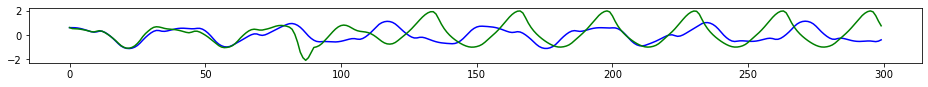

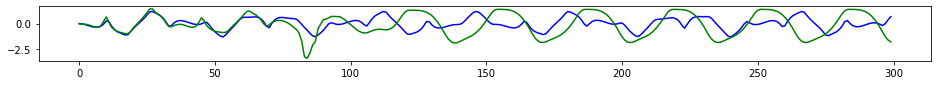

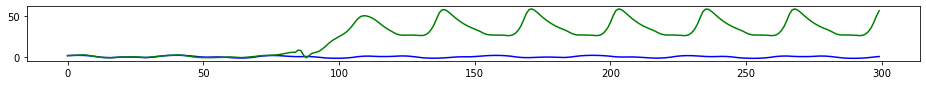

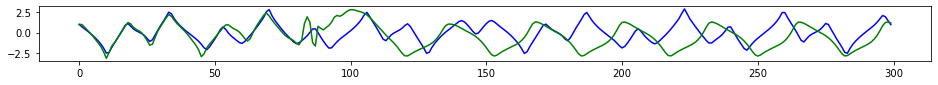

In [11]:
idx = 3
for col in range(4):
    plt.figure(figsize=(16,1))
    plt.plot(dp_data2[idx][0:300,col], "blue")
    plt.plot(dp_pred2[idx][0:300,col], "green")